In [182]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [174]:
def read_bin(filename):
    data = []
    with open(filename,"rb") as fr:
        try:
            while True:
                data.append(pickle.load(fr))
        except EOFError:
            pass
    return data

def create_bin(filename, data):
    file = open(filename, "wb+")
    pickle.dump(data, file)
    return file

def append_bin(file, data):
    pickle.dump(data, file)
    return


In [175]:
def ADROP(data, ans, model, drop_mode="Average", data_mode="Normal"):
    """

    Function to apply the Machine Learning Transition State Analysis to a given training dataset/answers and trained
    model. It calculates the Gloabl Means and re-calculates accuracy for predicting each outcome.

    :param data: Training data used for training the ML model. Must have shape (samples, features)
    :type data: list
    :param ans: Outcomes for each sample on "data". Shape must be (samples)
    :type ans: list
    :param model:
    :param drop_mode:
    :param data_mode:
    :return:

    """

    if data_mode == "Rigged":
        data = data[:, :-1, :]

    # Calculating the global means
    means_per_sim = np.mean(data.T, axis=1)
    gmeans = np.mean(means_per_sim, axis=1)
    temp_sim_data = np.copy(data)

    # Swapping the values and predicting for the FR
    FR = []
    for y, data in tqdm(enumerate(temp_sim_data)):
        mean_sim = []
        for n, mean in enumerate(gmeans):
            tmp_dat = np.copy(data)
            tmp_dat.T[n, :] = mean
            yy = np.zeros(len(tmp_dat)).astype(str)
            yy[:] = ans[y]
            res = model.score(tmp_dat, yy)
            mean_sim.append(res)
        FR.append(mean_sim)

    if drop_mode == "Median":
        median = np.median(np.array(FR).T, axis=0)
        median = np.median(median, axis=0)
        dv_from_median = []
        for n, M in enumerate(median):
            dv_from_median.append(abs(M - np.array(FR)[n].T))
        fr = np.mean(np.array(dv_from_median), axis=1)
        fr = np.mean(fr, axis=0)
    return FR

In [124]:
labelled_sims = np.loadtxt("data/labels.txt", dtype=str)

In [125]:
ranges = np.arange(0, 400, 100)

data = []
for R in ranges:
    for entry in read_bin(f"data/CV_{R}_{R+100}.bin"):
        # if len(d) < 1000:
        #     continue
        # else:
        data.append(entry[0])

In [136]:
ex_idx = []
for n, d in enumerate(data):
    if len(d) < 1000:
        #print(len(d), n)
        ex_idx.append(labelled_sims.T[0][n])

IndexError: index 105 is out of bounds for axis 0 with size 105

In [139]:
ex_idx

['31', '61', '112', '161', '211', '261', '311']

In [170]:
ranges = np.arange(0, 400, 100)

data = []
for R in ranges:
    for entry in read_bin(f"data/CV_{R}_{R+100}.bin"):
        if len(entry[0]) < 1000:
            continue
        else:
            data.append(entry[0])
            
data = np.array(data)

In [171]:
labelled_sims = np.loadtxt("data/labels_fix.txt", dtype=str)
answers = labelled_sims.T[1]

In [145]:
len(labelled_sims) == len(data)

True

In [267]:
INS = np.where(answers == "IN")[0]
OUTS = np.where(answers == "OUT")[0]
minimum = np.min([len(data[INS]), len(data[OUTS])])
#in_sims = INS[:minimum]
in_sims = INS[:40]
out_sims = OUTS[:minimum]
balanced = np.concatenate((in_sims, out_sims))

balanced_data = data[balanced]
balanced_answers = answers[balanced]

### MLTSA with a Multi-Layer Perceptron (MLP) 

In [268]:
from MLTSA_sklearn.models import SKL_Train
from sklearn.neural_network import MLPClassifier

In [269]:
X = np.concatenate(balanced_data)
template = []
for ans in balanced_answers:
    tmp = np.zeros(len(data[0])).astype(str)
    tmp[:] = ans
    template.append(tmp)
Y = np.concatenate(template)
NN = MLPClassifier(random_state=1, verbose=0, max_iter=500) # You can set the verbose to false for less prints.
trained_NN, train_acc, test_acc = SKL_Train(NN, X, Y)

Accuracy on Train is 94.96296296296296
Accuracy on Test set is 95.14920634920635
Trained in  26.387988090515137 seconds


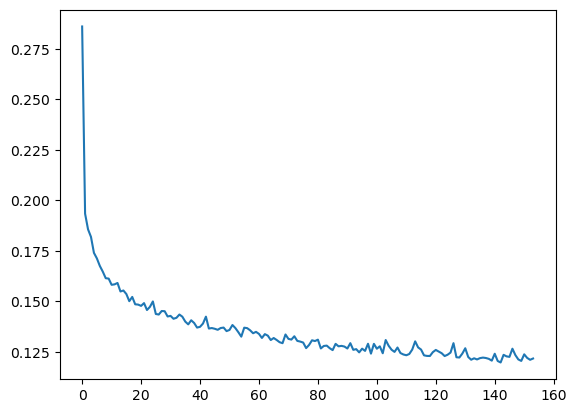

In [270]:
plt.plot(NN.loss_curve_)

## Training through time! 


In [266]:
#time_frames = np.geomspace(1, 500, 20).astype(int)
time_frames, step = np.linspace(20, 1000, 10, retstep=True)
step = int(step)

results = {}
for n, time in enumerate(time_frames.astype(int)): 
    results[time] = {}
    XX = np.concatenate(balanced_data[time:time+step])
    YY = np.concatenate(template[time:time+step])
    NN = MLPClassifier(random_state=1, verbose=0, max_iter=500) # You can set the verbose to false for less prints.
    trained_NN, train_acc, test_acc = SKL_Train(NN, XX, YY)
    results[time]["acc"] = [train_acc, test_acc]
    results[time]["model"] = NN
    print("Calculating ADROP")
    results[time]["adrop"] = ADROP(balanced_data[:,:time, :], answers, NN)


Accuracy on Train is 98.08717948717948
Accuracy on Test set is 98.32307692307693
Trained in  9.835941314697266 seconds
Calculating ADROP


46it [00:03, 14.93it/s]


ValueError: need at least one array to concatenate

In [265]:
time

265

In [ ]:
t_acc = []
tr_acc = []
for time in time_frames: 
    train, test = results[time]["acc"]
    t_acc.append(test)
    tr_acc.append(train)
plt.plot(time_frames, t_acc, label="test")
plt.plot(time_frames, tr_acc, label="train")
plt.legend()

In [228]:
test

0.9384347826086956

## MLTSA with a Gradient Boosting Decision Tree (GBDT)